# Benchmarking spiking and regular networks

This notebook builds and compares the convergence and runtime of spiking networks, convolutional and regular feedforward neural networks. 



## Step 0: Define parameters for training

In [1]:
import torch

T = 200
DEVICE = torch.device("cuda")
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

LOG_INTERVAL = 10
EPOCHS = 10

## Step 1: Download MNIST data

In [2]:
import torch
import torchvision

BATCH_SIZE = 32

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=True,
        download=True,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE
)

## Step 2: Add spike encoding/decoding

In [3]:
from norse.torch.module.lif import LIFConstantCurrentEncoder

class Encoder(torch.nn.Module):
    def __init__(self, seq_length, device):
        super(Encoder, self).__init__()
        self.constant_current_encoder = LIFConstantCurrentEncoder(
            seq_length=seq_length, device=device
        )

    def forward(self, x):
        _, x = self.constant_current_encoder(x)
        return x
    
    
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

## Step 3: Build simple spiking model

In [4]:
from norse.torch.module.lif import LIFCell, LIFParameters, LIFFeedForwardCell
from norse.torch.module.leaky_integrator import LIFeedForwardCell

class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super(SNN, self).__init__()
        self.l1 = LIFCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100)                        
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LIFeedForwardCell(shape=(output_features,))

        
    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = self.l1.initial_state(batch_size, x.device, torch.float)
        so = self.out.initial_state(batch_size, x.device)
        voltages = []

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            voltages += [vo]

        return torch.stack(voltages)

class SNNModel(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(SNNModel, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [5]:
snn_model = SNNModel(
    encoder=Encoder(
      device=DEVICE,
      seq_length=T,
    ),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=LR)
snn_model

SNNModel(
  (encoder): Encoder(
    (constant_current_encoder): LIFConstantCurrentEncoder()
  )
  (snn): SNN(
    (l1): LIFCell(784, 100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LIFeedForwardCell()
  )
)

## Step 4: Build simple CNN model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Example from: https://github.com/pytorch/examples
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
import torch.optim as optim

cnn_model = CNNModel().to(DEVICE)
cnn_optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
cnn_model

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Step 5: Define training, testing and model evaluation

In [8]:
from tqdm import tqdm
import numpy as np

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=True, position=0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [9]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()¶

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [10]:
def evaluate(model, optimizer):
    training_losses = []
    mean_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(EPOCHS):
        training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
        test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
        training_losses += training_loss
        mean_losses.append(mean_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)       
        print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)
    return training_losses, mean_losses, test_losses, accuracies

## Step 6: Train

In [11]:
%%time 
cnn_results = evaluate(cnn_model, cnn_optimizer)

100%|██████████| 1875/1875 [00:15<00:00, 120.68it/s]


epoch: 0, mean_loss: 0.43953546885649364, test_loss: 0.14911142818927764, accuracy: 95.7


100%|██████████| 1875/1875 [00:15<00:00, 120.37it/s]


epoch: 1, mean_loss: 0.20139083608786265, test_loss: 0.08689898804426194, accuracy: 97.26
CPU times: user 31.6 s, sys: 2.72 s, total: 34.3 s
Wall time: 34.2 s


In [12]:
%%time
snn_results = evaluate(snn_model, snn_optimizer)

100%|██████████| 1875/1875 [08:28<00:00,  3.69it/s]


epoch: 0, mean_loss: 0.3642238063017527, test_loss: 0.210716992521286, accuracy: 93.74


100%|██████████| 1875/1875 [08:12<00:00,  3.81it/s]


epoch: 1, mean_loss: 0.18751669102509816, test_loss: 0.17099275662899016, accuracy: 94.74
CPU times: user 18min 8s, sys: 982 ms, total: 18min 9s
Wall time: 18min 8s


## Step 7: Compare

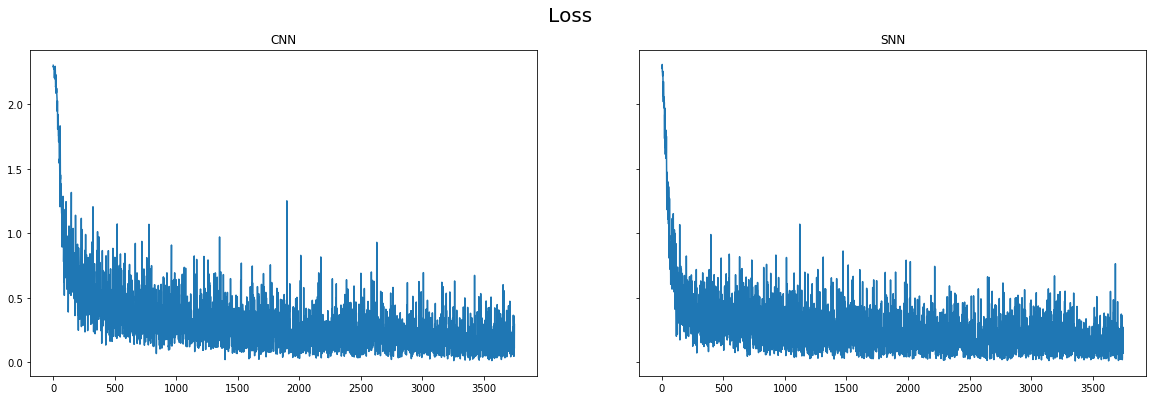

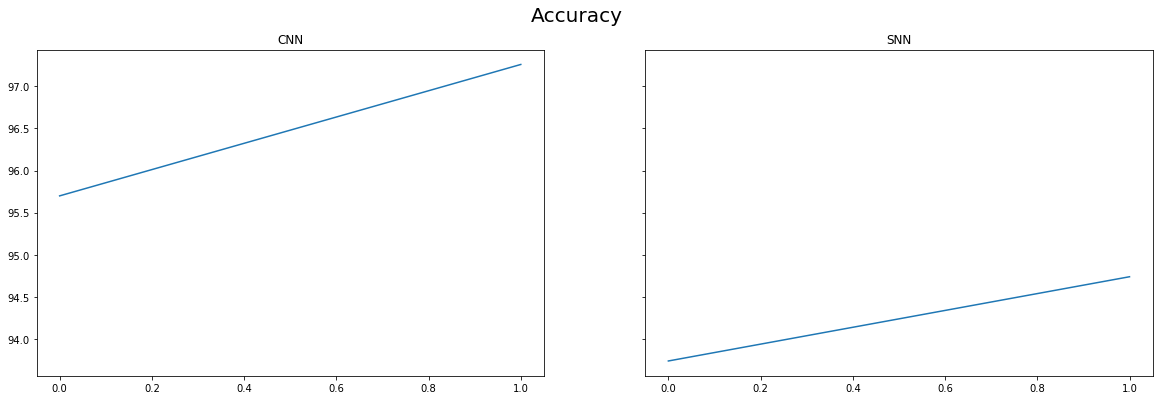

In [47]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))
f.suptitle("Loss", fontsize=20)
ax1.set_title("CNN")
ax1.plot(cnn_results[0])
ax2.set_title("SNN")
ax2.plot(snn_results[0])
f, (ax3, ax4) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))
f.suptitle("Accuracy", fontsize=20)
ax3.set_title("CNN")
ax3.plot(cnn_results[3])
ax4.set_title("SNN")
ax4.plot(snn_results[3])
#plt.savefig("results.png")